In [ ]:
import re
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import json

SMALL_BERT: bool = True
MODEL_NAME : str = "distilbert-base-cased" if SMALL_BERT else "bert-large-uncased"
OUTPUT_DIR : str = f"{MODEL_NAME}-pos-tagger"
FINAL_SAVE_DIR : str = f"{OUTPUT_DIR}-final"
ROOT = "."

In [ ]:
dataset = load_dataset("universal_dependencies", "en_ewt",trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

pos_tags = dataset["train"].features["upos"].feature.names
id2label = {i: tag for i, tag in enumerate(pos_tags)}
label2id = {tag: i for i, tag in enumerate(pos_tags)}
num_labels = len(pos_tags)

idx: weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0001
text: Al-Zaman : American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town of Qaim, near the Syrian border.
tokens: ['Al', '-', 'Zaman', ':', 'American', 'forces', 'killed', 'Shaikh', 'Abdullah', 'al']... (length: 29)
lemmas: ['Al', '-', 'Zaman', ':', 'american', 'force', 'kill', 'Shaikh', 'Abdullah', 'al']... (length: 29)
upos: [10, 1, 10, 1, 6, 0, 16, 10, 10, 10]... (length: 29)
xpos: ['NNP', 'HYPH', 'NNP', ':', 'JJ', 'NNS', 'VBD', 'NNP', 'NNP', 'NNP']... (length: 29)
feats: ["{'Number': 'Sing'}", 'None', "{'Number': 'Sing'}", 'None', "{'Degree': 'Pos'}", "{'Number': 'Plur'}", "{'Mood': 'Ind', 'Tense': 'Past', 'VerbForm': 'Fin'}", "{'Number': 'Sing'}", "{'Number': 'Sing'}", "{'Number': 'Sing'}"]... (length: 29)
head: ['0', '1', '1', '1', '6', '7', '1', '7', '8', '8']... (length: 29)
deprel: ['root', 'punct', 'flat', 'punct', 'amod', 'nsubj', 'parataxis', 'obj', 'flat', 'flat']... (le

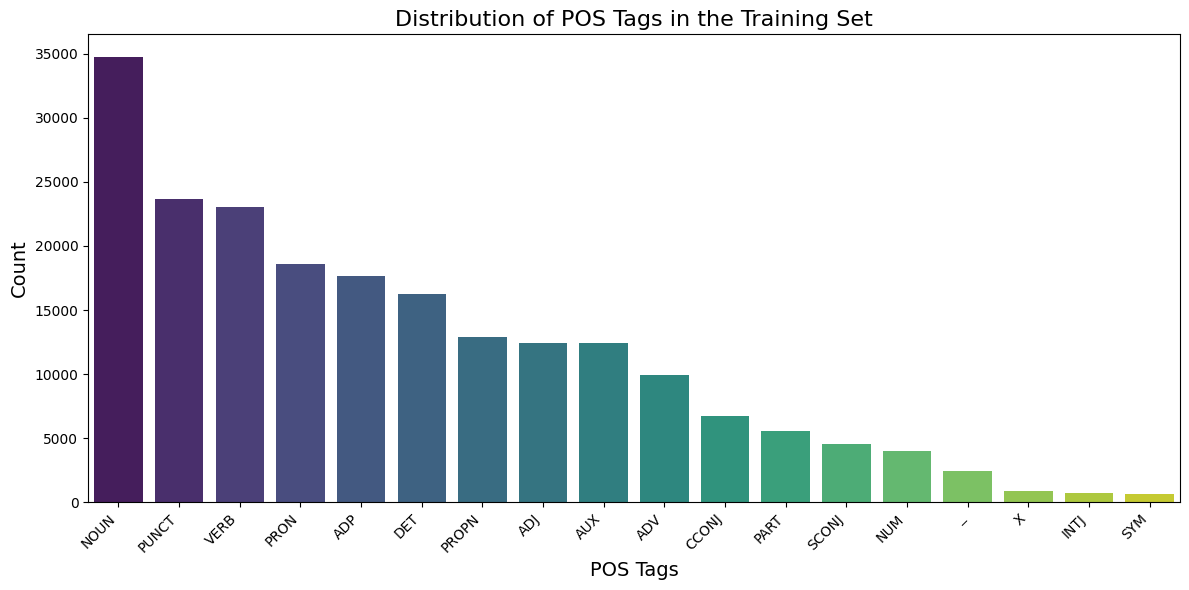

In [ ]:
def debug_example(example_idx=0):
    """Debug a single example to check token and label alignment."""
    example = dataset["train"][example_idx]
    for key in example:
        if isinstance(example[key], list):
            print(f"{key}: {example[key][:10]}... (length: {len(example[key])})")
        else:
            print(f"{key}: {example[key]}")

    if len(example['tokens']) != len(example['upos']):
        print(f"WARNING: Length mismatch! tokens: {len(example['tokens'])}, upos: {len(example['upos'])}")
    
    for i, tag_id in enumerate(example['upos']):
        if not 0 <= tag_id < num_labels:
            print(f"WARNING: Invalid tag ID '{tag_id}' at position {i}")
            
    tokenized = tokenizer(example['tokens'], is_split_into_words=True)
    print(f"Token to word mapping: {tokenized.word_ids()}")

debug_example(0)

def plot_pos_distribution(dataset, id2label):
    pos_counts = Counter()
    for example in dataset["train"]:
        pos_counts.update(example["upos"])
    
    sorted_pos_counts = sorted(pos_counts.items(), key=lambda x: x[1], reverse=True)
    tags = [id2label[tag_id] for tag_id, _ in sorted_pos_counts]
    counts = [count for _, count in sorted_pos_counts]
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=tags, y=counts, palette="viridis", hue=tags, legend=False)
    plt.title("Distribution of POS Tags in the Training Set", fontsize=16)
    plt.xlabel("POS Tags", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plot_pos_distribution(dataset, id2label)

In [ ]:
def tokenize_and_align_labels(examples):
    """Tokenize and align labels with tokenized inputs."""
    tokenized_inputs = tokenizer(
        examples["tokens"], 
        truncation=True, 
        is_split_into_words=True,
        padding="max_length",
        max_length=128,
        return_tensors=None
    )
    
    all_labels = []
    for i, example_labels in enumerate(examples["upos"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                if word_idx < len(example_labels):
                    tag_id = example_labels[word_idx]
                    label_ids.append(tag_id if 0 <= tag_id < num_labels else 0)
                else:
                    label_ids.append(-100)
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        
        if len(label_ids) != len(tokenized_inputs["input_ids"][i]):
            label_ids = label_ids[:len(tokenized_inputs["input_ids"][i])] + [-100] * (len(tokenized_inputs["input_ids"][i]) - len(label_ids))
        
        all_labels.append(label_ids)
    
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs


test_example = dataset["train"][0:1]
test_result = tokenize_and_align_labels(test_example)
print("Single example processed successfully!")

Single example processed successfully!


In [ ]:
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    batch_size=100,
    remove_columns=dataset["train"].column_names,
    desc="Tokenizing and aligning labels"
)
# For Testing
# small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(100))
# small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=42).select(range(100))
print("Tokenization complete!")

Tokenization complete!


In [6]:
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)
    
    true_predictions = [p for pred, label in zip(predictions, labels) for p, l in zip(pred, label) if l != -100]
    true_labels = [l for pred, label in zip(predictions, labels) for p, l in zip(pred, label) if l != -100]
    
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average='weighted', zero_division=0)
    acc = accuracy_score(true_labels, true_predictions)
    
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

def find_latest_checkpoint(output_dir):
    subdirs = [d for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, d))]
    
    checkpoint_dirs = [d for d in subdirs if re.match(r"checkpoint-\d+", d)]
    
    if not checkpoint_dirs:
        return None
    checkpoint_numbers = [int(re.search(r"checkpoint-(\d+)", d).group(1)) for d in checkpoint_dirs]
    
    latest_checkpoint_number = max(checkpoint_numbers)
    latest_checkpoint_dir = f"checkpoint-{latest_checkpoint_number}"
    
    return os.path.join(output_dir, latest_checkpoint_dir)

os.makedirs(f"{ROOT}/{OUTPUT_DIR}", exist_ok=True)
latest_checkpoint = find_latest_checkpoint(f"{ROOT}/{OUTPUT_DIR}")
if latest_checkpoint:
    print(f"Continuing from: {latest_checkpoint}")
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit = 3,
    report_to= "none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    processing_class=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train(resume_from_checkpoint=latest_checkpoint)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.299100,0.140887,0.960122,0.959957,0.960122,0.959963
2,0.082800,0.125005,0.965068,0.964840,0.965068,0.964828
3,0.050200,0.129710,0.966049,0.965870,0.966049,0.965914
4,0.032200,0.140005,0.967030,0.966953,0.967030,0.966897
5,0.021700,0.156925,0.966363,0.966286,0.966363,0.966053
6,0.014800,0.163914,0.967462,0.967348,0.967462,0.967386
7,0.010400,0.170714,0.967148,0.966995,0.967148,0.967053
8,0.007400,0.181155,0.967580,0.967404,0.967580,0.967452
9,0.005900,0.183510,0.968051,0.967854,0.968051,0.967876
10,0.005100,0.182901,0.967933,0.967723,0.967933,0.967789


TrainOutput(global_step=7840, training_loss=0.05296785253651288, metrics={'train_runtime': 6704.4082, 'train_samples_per_second': 18.709, 'train_steps_per_second': 1.169, 'total_flos': 4098139831526400.0, 'train_loss': 0.05296785253651288, 'epoch': 10.0})

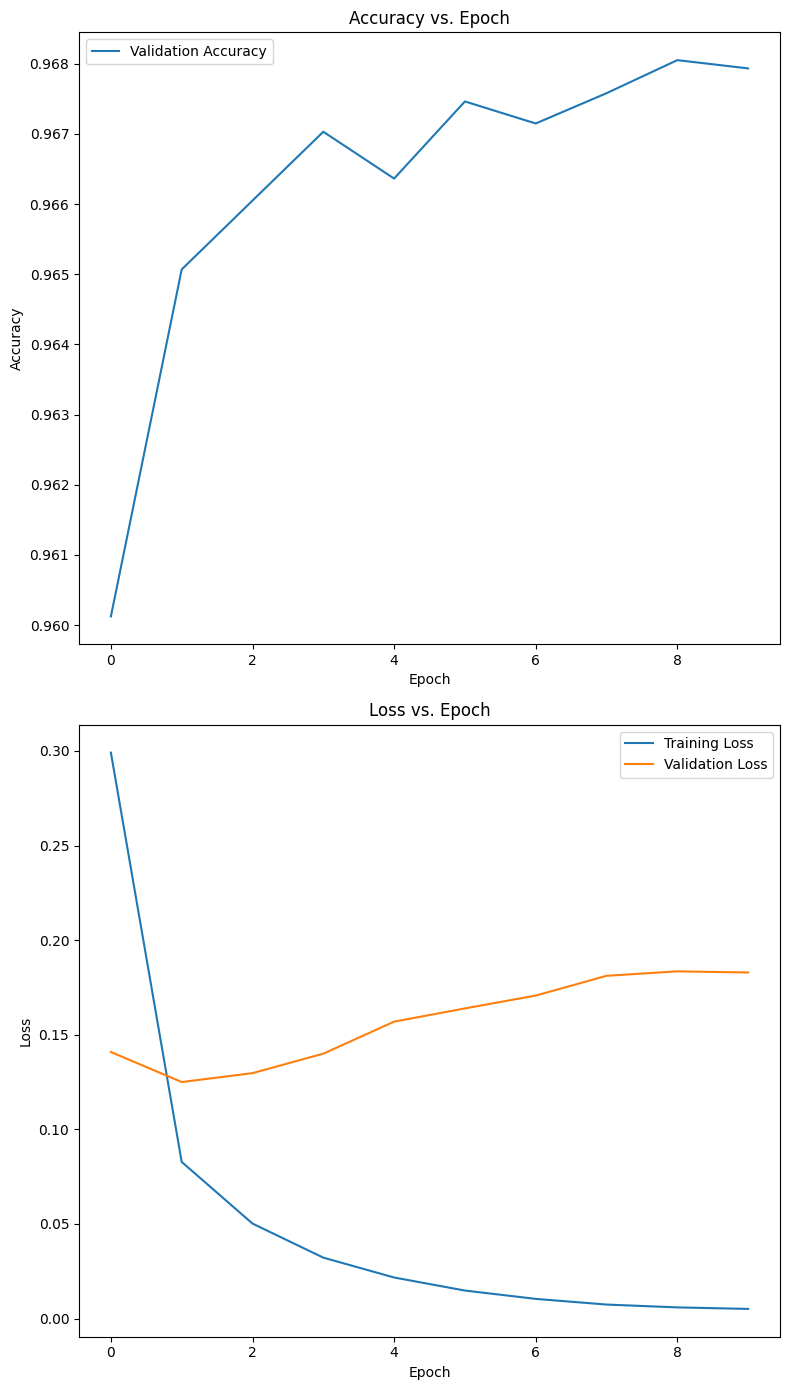

In [ ]:
def plot_metrics(logs):
    train_losses = [entry["loss"] for entry in logs if "loss" in entry]
    eval_losses = [entry["eval_loss"] for entry in logs if "eval_loss" in entry]
    accuracies = [entry["eval_accuracy"] for entry in logs if "eval_accuracy" in entry]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 14))
    ax1.plot(accuracies, label='Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.set_title('Accuracy vs. Epoch')
    
    ax2.plot(train_losses, label='Training Loss')
    ax2.plot(eval_losses, label='Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.set_title('Loss vs. Epoch')
    
    plt.tight_layout()
    plt.show()

plot_metrics(trainer.state.log_history)

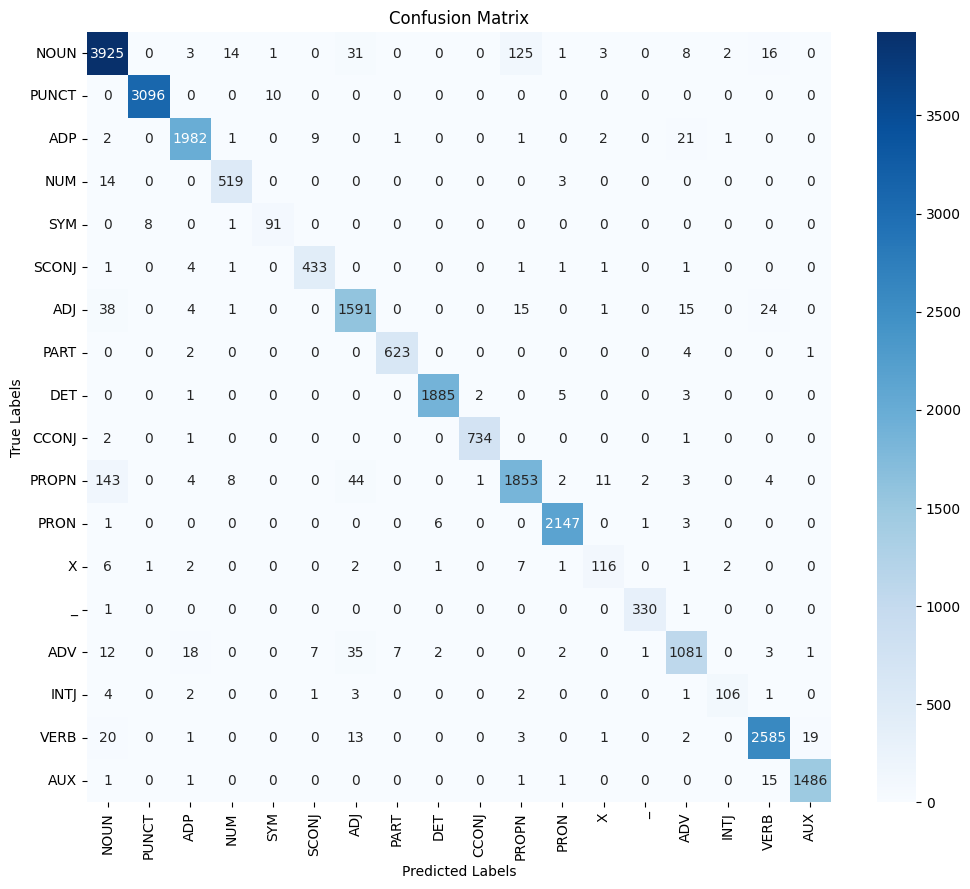

In [9]:
def evaluate_and_plot_confusion_matrix(trainer, tokenized_datasets, pos_tags):
    predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
    predictions = np.argmax(predictions, axis=2)
    
    true_predictions = [p for pred, label in zip(predictions, labels) for p, l in zip(pred, label) if l != -100]
    true_labels = [l for pred, label in zip(predictions, labels) for p, l in zip(pred, label) if l != -100]
    
    cm = confusion_matrix(true_labels, true_predictions)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=pos_tags, yticklabels=pos_tags)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_and_plot_confusion_matrix(trainer, tokenized_datasets, pos_tags)

In [ ]:
def save_modules():
    trainer.save_model(f"{ROOT}/{FINAL_SAVE_DIR}")
    with open(f"{ROOT}/{FINAL_SAVE_DIR}/label_mappings.json", "w") as f:
        json.dump({"id2label": id2label, "label2id": label2id}, f)
    tokenizer.save_pretrained(f"{ROOT}/{FINAL_SAVE_DIR}")
    print(f"Model saved to {ROOT}/{FINAL_SAVE_DIR}")
    
save_modules()

Model saved to ./distilbert-base-cased-pos-tagger-final/
